<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Multinomial_Models/Example_Multinomial_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

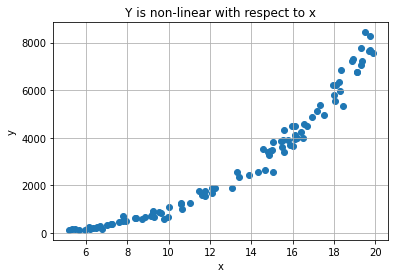

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a sample dataset
x = np.random.uniform(low=5, high=20, size=100)
e = np.random.normal(loc=0, scale=0.5, size=100)
y = (x + e)**3

fig, ax = plt.subplots(1,1)
ax.scatter(x,y)
ax.set_title('Y is non-linear with respect to x')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
fig.show()


In [2]:
# build a ridge regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

x = x.reshape(x.shape[0],1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

rgr = Ridge()
rgr.fit(x_train, y_train)
y_test_pred = rgr.predict(x_test)
mae = mean_absolute_error(y_test, y_test_pred)
print(f'MAE: {mae:.2f}')

MAE: 634.73


In [3]:
# transforming the target variable
class YTransformer:
  def __init__(self, power=1):
      self.power = power

  def fit(self, x, y):
    pass

  def transform(self, x, y):
    return x, np.power(y, self.power)

  def inverse_transform(self, x, y):
    return x, np.power(y, 1/self.power)
  
  def fit_transform(self, x, y):
    return self.transform(x, y)

In [4]:
from sklearn.metrics import r2_score

for power in [1, 1/2, 1/3, 1/4, 1/5]:
  yt = YTransformer(power)
  _, y_train_t = yt.fit_transform(None, y_train)
  _, y_test_t = yt.transform(None, y_test)
  rgs = Ridge()
  rgs.fit(x_train, y_train_t)
  y_pred_t = rgs.predict(x_test)
  _, y_pred = yt.inverse_transform(None, y_pred_t)
  print(
      'Transformed y^{:.2f}: MAE={:.0f}, R2={:.2f}'.format(
          power, mean_absolute_error(y_test, y_pred),
          r2_score(y_test, y_pred)
      )
  )

Transformed y^1.00: MAE=635, R2=0.91
Transformed y^0.50: MAE=239, R2=0.98
Transformed y^0.33: MAE=192, R2=0.99
Transformed y^0.25: MAE=232, R2=0.98
Transformed y^0.20: MAE=269, R2=0.98


In [8]:
# Estimating multiple regression targets
# Builing a multi-output regressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor

x, y = make_regression(n_samples=500, n_features=8, n_informative=8, n_targets=3, noise=30.0)
feature_names = [f'Feature # {i}' for i in range(x.shape[1])]
target_names = [f'Target # {i}' for i in range(y.shape[1])]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

rgr = MultiOutputRegressor(estimator=SGDRegressor(), n_jobs=-1)
rgr.fit(x_train, y_train)
y_pred = rgr.predict(x_test)

df_pred = pd.DataFrame(y_pred, columns=target_names)
df_pred.head(3)

,Target # 0,Target # 1,Target # 2
0,265.278773,-23.824486,94.627962
1,209.776171,102.590222,97.219886
2,-25.214785,-11.317393,-209.365123


In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

for t in range(y_train.shape[1]):
  print('Target # {}: MAE={:.2f}, R2={:.2f}'.format(
      t, mean_absolute_error(y_test[t], y_pred[t]),
      r2_score(y_test[t], y_pred[t])
  ))

Target # 0: MAE=13.83, R2=0.99
Target # 1: MAE=33.35, R2=0.71
Target # 2: MAE=13.71, R2=0.97


In [10]:
# Chaining multiple regressors
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import Ridge

rgr = RegressorChain(base_estimator=Ridge(alpha=1), order=[0,1,2])
rgr.fit(x_train, y_train)
y_pred = rgr.predict(x_test)

pd.DataFrame(zip(rgr.estimators_[-1].coef_, feature_names + target_names),
             columns=['Coeff', 'Feature'])[['Feature', 'Coeff']].style.bar(
                 subset=['Coeff'], align='mid', color='#AAAAAA'
             )

,Feature,Coeff
0,Feature # 0,27.388570
1,Feature # 1,26.214323
2,Feature # 2,54.084751
3,Feature # 3,24.896933
4,Feature # 4,69.092560
5,Feature # 5,14.189692
6,Feature # 6,17.307925
7,Feature # 7,84.738506
8,Target # 0,0.075976
9,Target # 1,-0.000901
